# Open problems: solution to exercise 1

Let's simulate the source and then fit its properties with the model used for the simulation.

In [1]:
import matplotlib.pyplot as plt

from pathlib import Path
import time
import numpy as np
import threading
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.io import fits
from astropy.time import Time
from regions import CircleSkyRegion, PointSkyRegion
from gammapy.data import Observation, observatory_locations, FixedPointingInfo, PointingMode
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import MapDatasetMaker
from gammapy.maps import MapAxis, RegionNDMap, WcsGeom, Map
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ConstantSpectralModel,
    FoVBackgroundModel,
    LightCurveTemplateTemporalModel,
    GaussianSpatialModel,
    GaussianTemporalModel,
    ConstantTemporalModel,
    ExpDecayTemporalModel,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
    Models
)

In [2]:
# let's create the source sky-model plus the background:

target = SkyCoord("335 deg", "33 deg", unit="deg", frame="icrs")
spatial_model = model = GaussianSpatialModel(
                            lon_0="335 deg",
                            lat_0="33 deg",
                            sigma="0.5 deg",
                            frame="icrs",
                            )

spectral_model = PowerLawSpectralModel(index=2, amplitude="1e-13 cm-2 s-1 TeV-1", reference="1 TeV")

temporal_model = ConstantTemporalModel(const=1)

In [3]:
source_model = SkyModel(spectral_model = spectral_model,
                       spatial_model = spatial_model,
                       temporal_model = temporal_model,
                       name = "fake_src")

bkg = FoVBackgroundModel(dataset_name="my-dataset")

full_model = Models([source_model, bkg])

print(full_model)

Models

Component 0: SkyModel

  Name                      : fake_src
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : ConstantTemporalModel
  Parameters:
    index                         :      2.000   +/-    0.00             
    amplitude                     :   1.00e-13   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    335.000   +/-    0.00 deg         
    lat_0                         :     33.000   +/-    0.00 deg         
    sigma                         :      0.500   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : P

In [4]:
# let's create the observation and the dataset

energy_axis = MapAxis.from_energy_bounds("0.012589254 TeV", "199.52623 TeV",
                                         nbin=10, per_decade=True)
energy_axis_true = MapAxis.from_energy_bounds("0.001 TeV", "250 TeV", 
                                         nbin=10, per_decade=True, 
                                         name="energy_true")
migra_axis = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

In [5]:
# let's set the pointing coordinates
pointing = target.directional_offset_by(position_angle = 0 * u.deg, separation = 0.5 * u.deg)

In [6]:
# let's load the IRF:
path = "../CALDB/CTA-Performance-prod5-v0.1-South-20deg/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz"
irf = load_irf_dict_from_file(path)

In [7]:
# let's define the geometry:
geom = WcsGeom.create(
            skydir=pointing,
            width=(2.5, 2.5), #deg
            binsz=0.02, #deg
            frame="icrs",
            axes=[energy_axis],
            )

empty = MapDataset.create(
            geom,
            energy_axis_true=energy_axis_true,
            migra_axis=migra_axis,
            name="my-dataset",
            )

In [8]:
# let's loop over the exposure times, fit the sampled events 
# and estimate the best-fit sizes:

time_ref = Time("2024-06-25T00:00:00", format="isot", scale="utc")

livetime = [0.5, 1, 2, 5, 10, 20, 50, 100] * u.hr

sigmas, errors = [], []
for exp in livetime:
    print(f"Simulation for exposure: {exp}")
    observation = Observation.create(
                obs_id="0001",
                pointing=pointing,
                livetime=exp,
                irfs=irf,
                reference_time=time_ref,
                )
    maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    dataset = maker.run(empty, observation)
    dataset.models = full_model

    sampler = MapDatasetEventSampler(random_state=0)
    events = sampler.run(dataset, observation)

    counts = Map.from_geom(geom)
    counts.fill_events(events)
    dataset.counts = counts

    dataset.models.parameters["lon_0"].frozen = True
    dataset.models.parameters["lat_0"].frozen = True

    fit = Fit()
    result = fit.run(dataset)
    sigmas.append(result.models[0].spatial_model.sigma.value)
    errors.append(result.models[0].spatial_model.sigma.error)
    print(result)

Simulation for exposure: 0.5 h


/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/data/observations.py:281: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
The meta information will be empty here.


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully, but uncertainties are unreliable.
	nfev       : 473
	total stat : 165888.63

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Simulation for exposure: 1.0 h


/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/data/observations.py:281: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/utils/random/inverse_cdf.py:32: RuntimeWarning: invalid value encountered in divide
  self.cdf /= self.cdf[:, [-1]]
The meta information will be empty here.


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 115
	total stat : 242439.34

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Simulation for exposure: 2.0 h


/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/data/observations.py:281: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
The meta information will be empty here.


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 103
	total stat : 307028.54

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Simulation for exposure: 5.0 h


/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/data/observations.py:281: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/utils/random/inverse_cdf.py:32: RuntimeWarning: invalid value encountered in divide
  self.cdf /= self.cdf[:, [-1]]
The meta information will be empty here.


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 95
	total stat : 184119.67

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Simulation for exposure: 10.0 h


/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/data/observations.py:281: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/utils/random/inverse_cdf.py:32: RuntimeWarning: invalid value encountered in divide
  self.cdf /= self.cdf[:, [-1]]
The meta information will be empty here.


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 85
	total stat : -516259.47

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Simulation for exposure: 20.0 h


/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/data/observations.py:281: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/utils/random/inverse_cdf.py:32: RuntimeWarning: invalid value encountered in divide
  self.cdf /= self.cdf[:, [-1]]
The meta information will be empty here.


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 105
	total stat : -2799652.60

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Simulation for exposure: 50.0 h


/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/data/observations.py:281: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/utils/random/inverse_cdf.py:32: RuntimeWarning: invalid value encountered in divide
  self.cdf /= self.cdf[:, [-1]]
The meta information will be empty here.


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization failed. Estimated distance to minimum too large.
	nfev       : 237
	total stat : -12826563.41

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Simulation for exposure: 100.0 h


/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/data/observations.py:281: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/utils/random/inverse_cdf.py:32: RuntimeWarning: invalid value encountered in divide
  self.cdf /= self.cdf[:, [-1]]
The meta information will be empty here.


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization failed. Estimated distance to minimum too large.
	nfev       : 201
	total stat : -34500397.66

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



Let's plot our results as a function of the exposure time:

Text(0.5, 1.0, 'Constrain on the source extension')

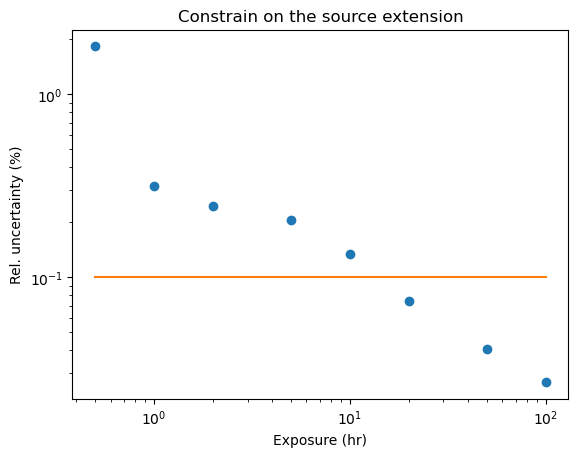

In [9]:
plt.plot(livetime, np.array(errors) / np.array(sigmas), "o")
plt.plot(livetime, np.ones_like(livetime)*0.10)
plt.loglog()
plt.xlabel("Exposure (hr)")
plt.ylabel("Rel. uncertainty (%)")
plt.title("Constrain on the source extension")